In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

import polars as pl
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.simplefilter('ignore')

from src.utils.utils_fn import *
%load_ext autoreload
%autoreload 2

In [2]:
# Definir la ruta absoluta para la carpeta de pipelines
root_path = Path.cwd().resolve().parent.parent

# Crear el directorio si no existe
root_path.mkdir(parents=True, exist_ok=True)

# Lectura del dataset
data = pl.read_parquet(
    source=str(root_path / 'data/processed/data_processed.parquet'), 
)
# Columnas innecesarias para el análisis exploratorio
ids_cols = ['product_id', 'title']
data = data.select([col for col in data.columns if col not in ids_cols]).to_pandas()
data.sample(5, random_state=10)

,condition,state,city,local_pickup,free_shipping,shipping_mode,listing_type,buying_mode,attribute_group_id,attribute_group,attribute_id,status,accepts_mercadopago,currency,automatic_relist,stock_quantity,available_quantity,total_amount,date_difference_hr,time_difference_hr
33226,used,capital federal,nuñez,True,False,not_specified,bronze,buy_it_now,None,None,None,active,True,ars,False,1,1,0.00,0.00,"1,440.00"
64804,used,buenos aires,avellaneda,True,False,not_specified,bronze,buy_it_now,dflt,otros,season,active,True,ars,False,8,8,0.00,695.49,"1,440.00"
39763,used,buenos aires,acassuso,True,False,me2,bronze,buy_it_now,None,None,None,active,True,ars,False,3,3,0.00,0.00,"1,440.00"
51270,used,capital federal,retiro,True,False,not_specified,free,buy_it_now,None,None,None,active,True,ars,False,1,1,0.00,0.00,"1,440.00"
9698,new,capital federal,almagro,True,False,not_specified,silver,buy_it_now,None,None,None,active,True,ars,False,7,7,"2,010.00",0.00,"1,440.00"


In [3]:
# Dimensiones del dataset
print(f'Número de muestras: {data.shape[0]}')
print(f'Predictores: {data.shape[1]}\n')
data.info()

Número de muestras: 100000
Predictores: 20

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   condition            100000 non-null  object 
 1   state                99997 non-null   object 
 2   city                 99996 non-null   object 
 3   local_pickup         100000 non-null  bool   
 4   free_shipping        100000 non-null  bool   
 5   shipping_mode        100000 non-null  object 
 6   listing_type         100000 non-null  object 
 7   buying_mode          100000 non-null  object 
 8   attribute_group_id   12425 non-null   object 
 9   attribute_group      12424 non-null   object 
 10  attribute_id         12425 non-null   object 
 11  status               100000 non-null  object 
 12  accepts_mercadopago  100000 non-null  bool   
 13  currency             100000 non-null  object 
 14  automatic_relist     1000

In [4]:
# Función para capturar los tipos de variables
continuous, categoricals, discretes, temporaries = capture_variables(
    data=data.loc[:, data.columns != 'condition'] # type: ignore
)

		Tipos de variables
Hay 5 variables continuas
Hay 0 variables discretas
Hay 0 variables temporales
Hay 14 variables categóricas


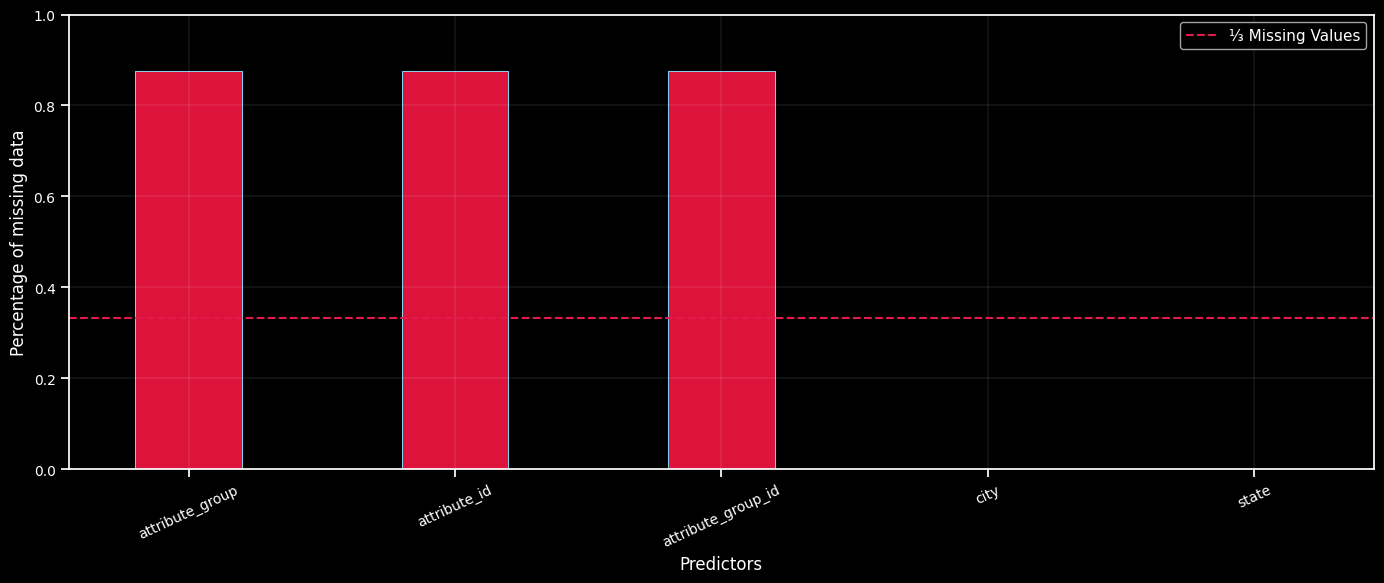

In [5]:
# Graficando los valores faltantes
plotting_nan_values(
    data=data.loc[:, data.columns != 'condition']
)

In [6]:
# Resumen estadístico de variables continuas
data[continuous].describe().T

,count,mean,std,min,25%,50%,75%,max
stock_quantity,"100,000.00",315.37,"7,320.49",1.00,2.00,4.00,12.00,"839,322.00"
available_quantity,"100,000.00",311.66,"7,293.96",1.00,2.00,4.00,10.00,"833,976.00"
total_amount,"100,000.00","20,332.91","1,324,519.89",0.00,0.00,0.00,0.00,"364,041,216.00"
date_difference_hr,"100,000.00",174.75,509.07,-0.00,0.00,0.00,145.61,"21,017.83"
time_difference_hr,"100,000.00","1,462.08",915.99,9.57,"1,440.00","1,440.00","1,440.00","82,969.25"


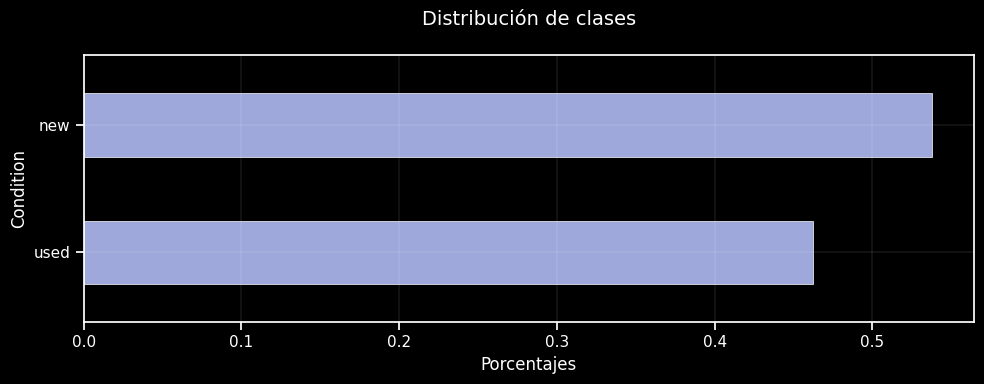

In [7]:
# Distribución de clases
class_distribution(
    data=data, 
    target='condition'
)

In [8]:
# Agregaciones agrupadas por el target
data.groupby('condition')[continuous].aggregate(['mean']).T

,condition,new,used
stock_quantity,mean,567.18,22.63
available_quantity,mean,560.34,22.56
total_amount,mean,"37,408.73",481.65
date_difference_hr,mean,214.33,128.74
time_difference_hr,mean,"1,472.47","1,450.00"


In [9]:
# Agregaciones agrupadas por el target
data.groupby('condition')[continuous].aggregate(['std']).T

,condition,new,used
stock_quantity,std,"9,974.45",266.11
available_quantity,std,"9,938.40",265.70
total_amount,std,"1,806,282.81","13,919.12"
date_difference_hr,std,556.46,443.30
time_difference_hr,std,"1,173.17",462.77


In [10]:
# Agregaciones agrupadas por el target
data.groupby('condition')[categoricals].aggregate(['count']).T

,condition,new,used
state,count,53757,46240
city,count,53757,46239
local_pickup,count,53758,46242
free_shipping,count,53758,46242
shipping_mode,count,53758,46242
listing_type,count,53758,46242
buying_mode,count,53758,46242
attribute_group_id,count,7433,4992
attribute_group,count,7433,4991
attribute_id,count,7433,4992


In [11]:
# Agregaciones agrupadas por el target
data.groupby('condition')[categoricals].aggregate(['nunique']).T

,condition,new,used
state,nunique,24,24
city,nunique,1781,1672
local_pickup,nunique,2,2
free_shipping,nunique,2,2
shipping_mode,nunique,4,3
listing_type,nunique,7,6
buying_mode,nunique,3,3
attribute_group_id,nunique,9,9
attribute_group,nunique,10,10
attribute_id,nunique,217,367


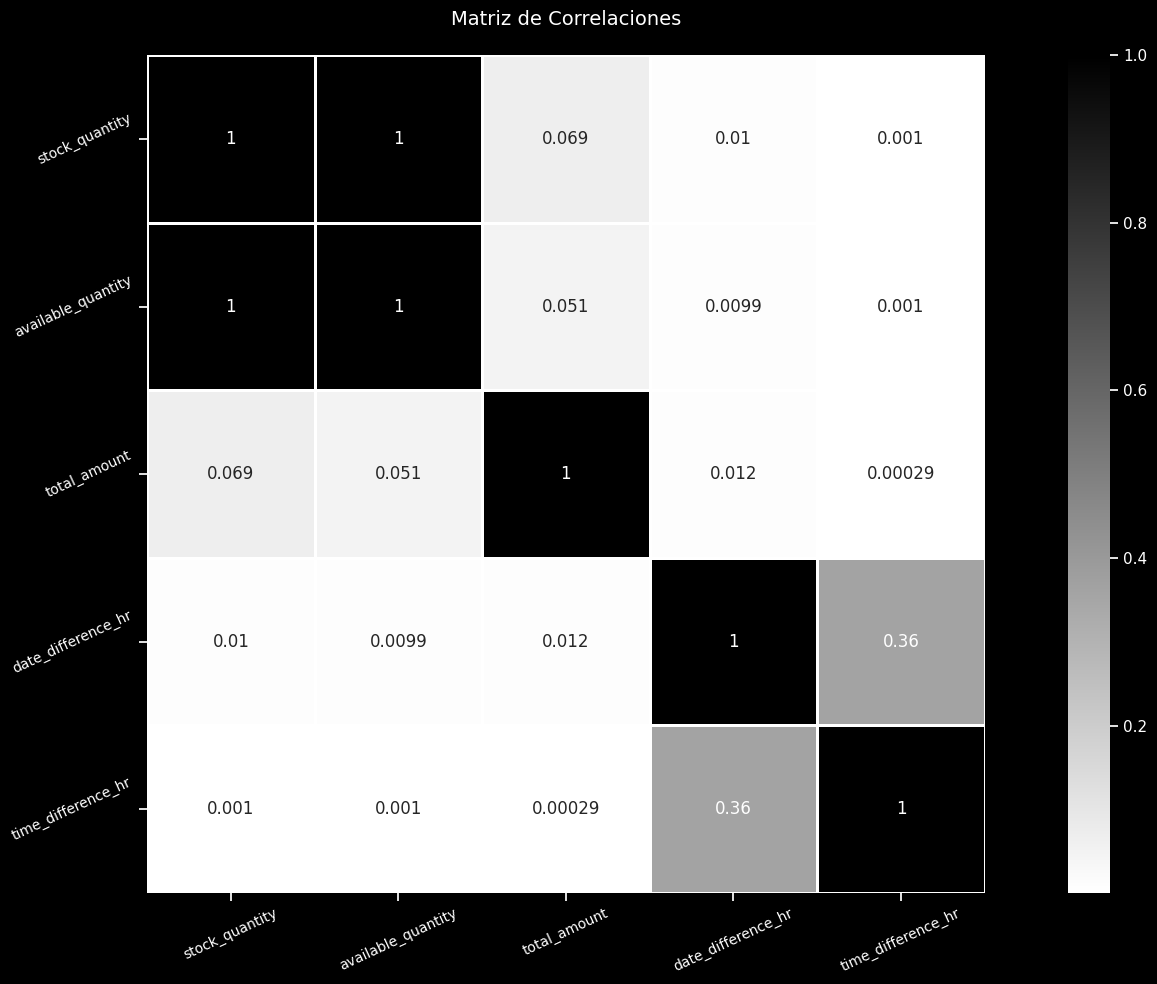

In [12]:
# Correlación entre predictores continuos
%matplotlib inline
continuous_correlation_matrix(
    data=data, 
    continuous=continuous
)

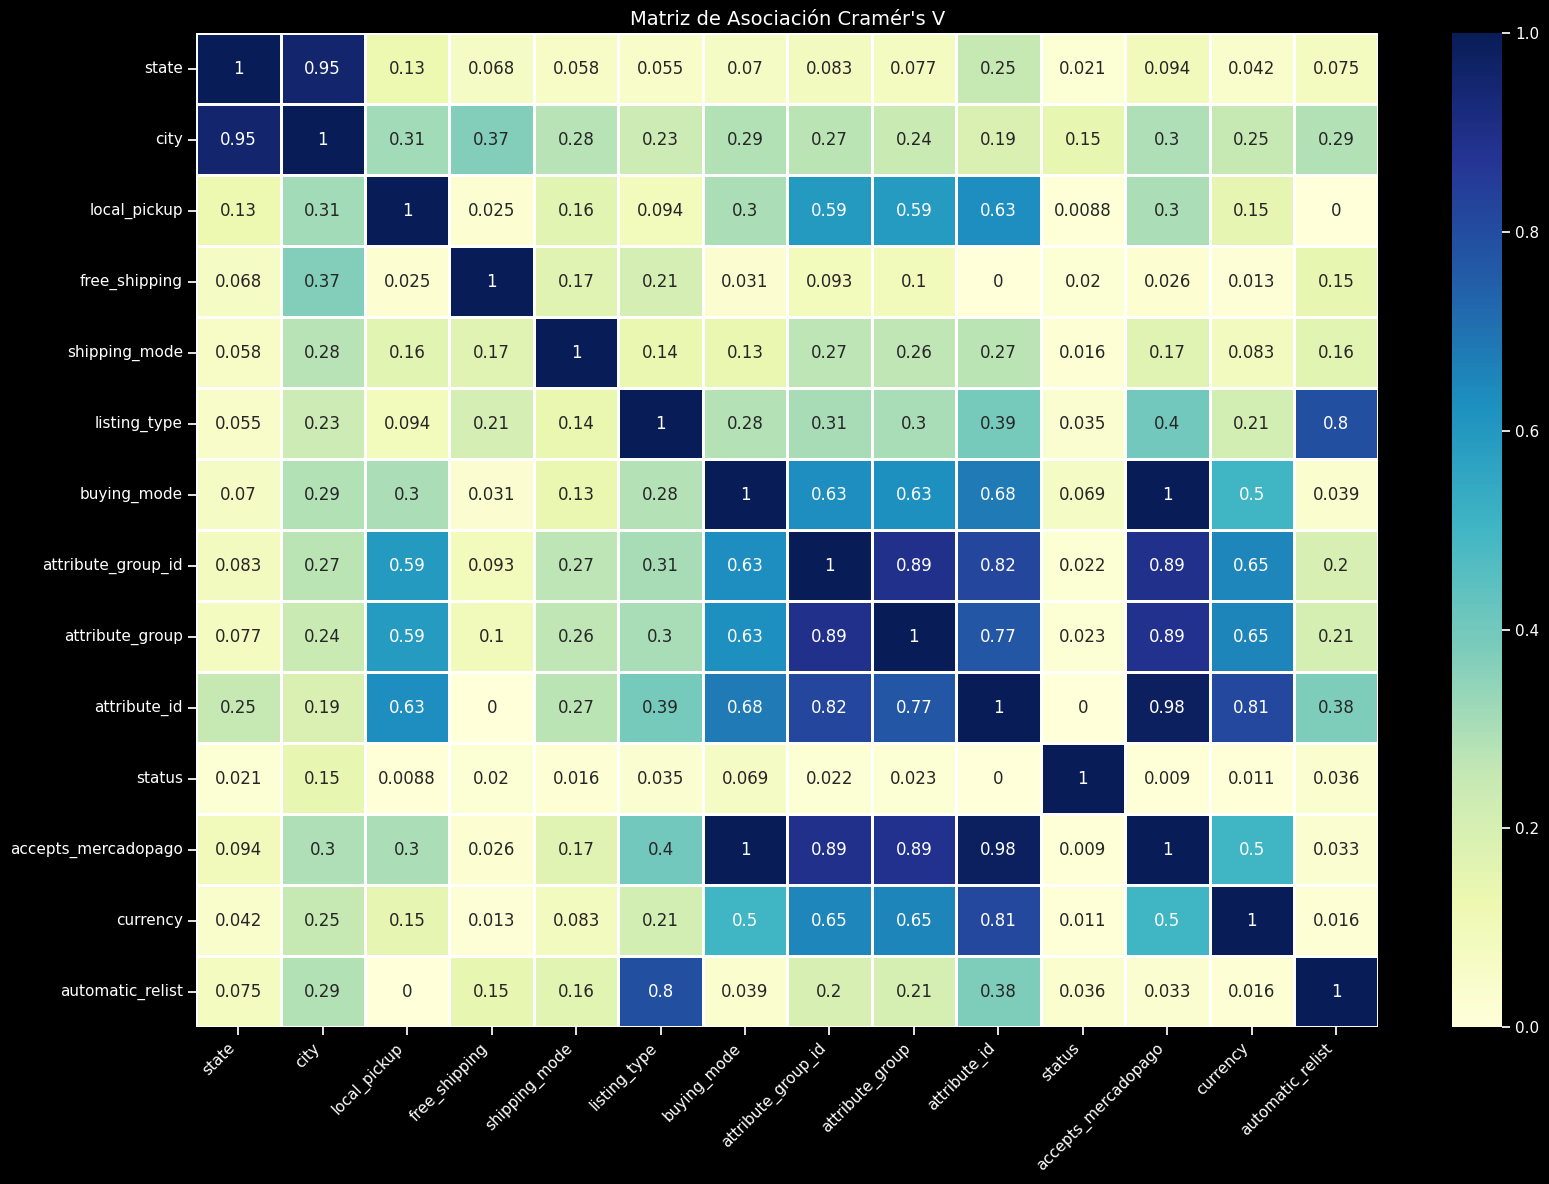

In [13]:
# Correlación entre predictores categóricos
%matplotlib inline
categoricals_correlation_matrix(
    data=data.loc[:, data.columns != 'condition'], # type: ignore, 
    categoricals=categoricals
)

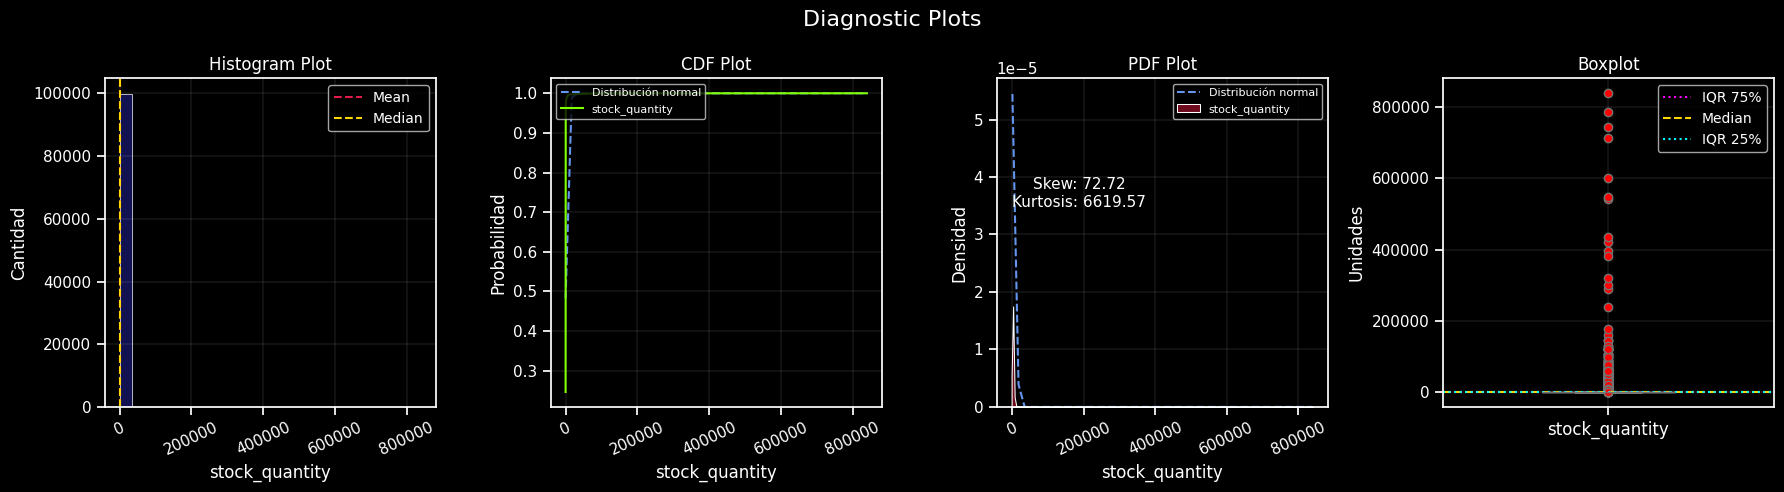

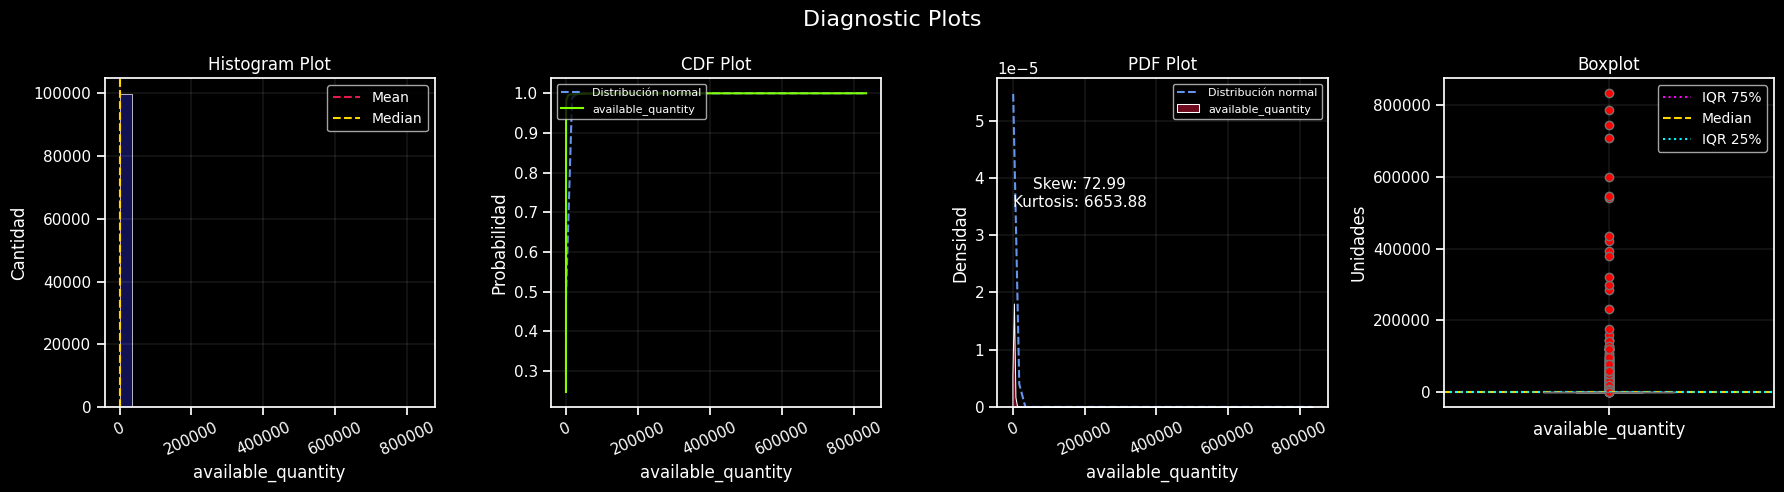

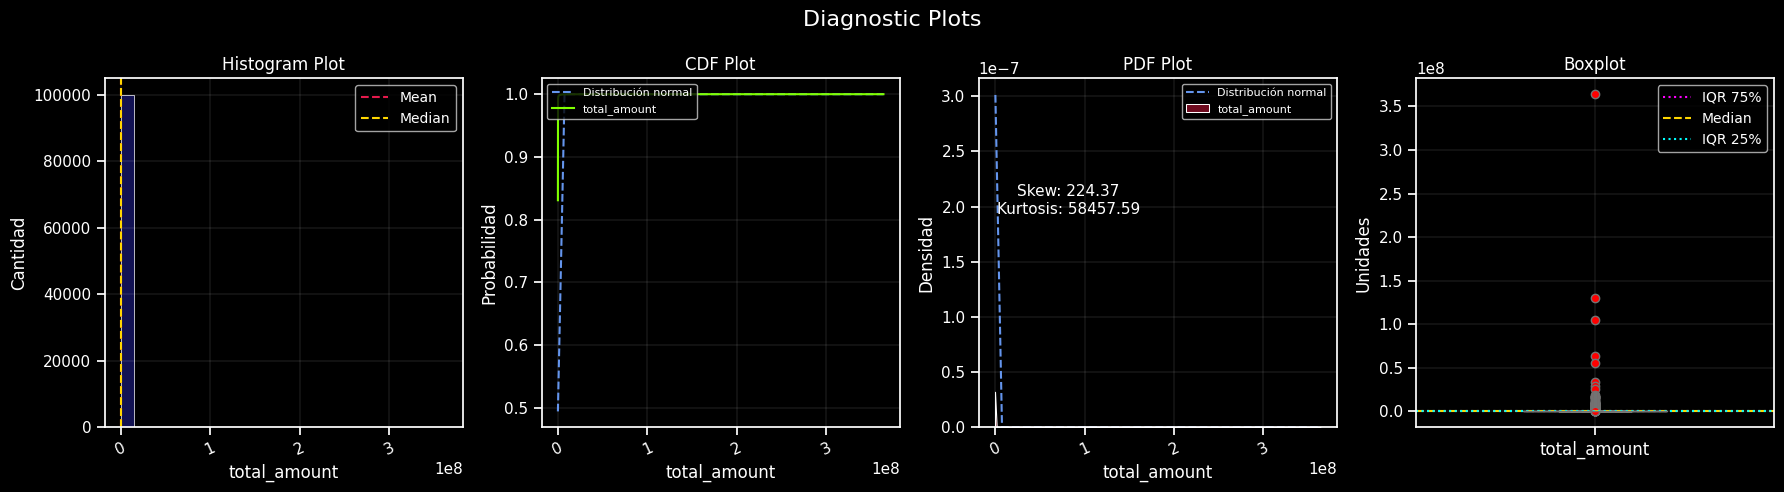

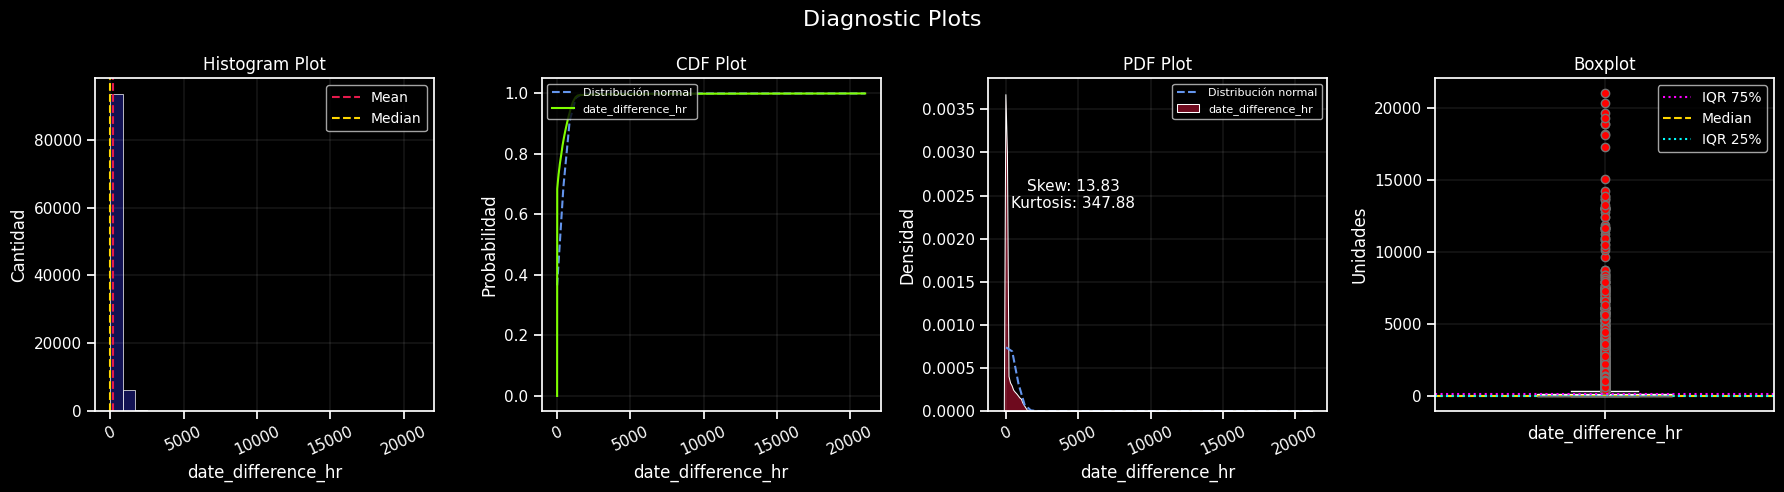

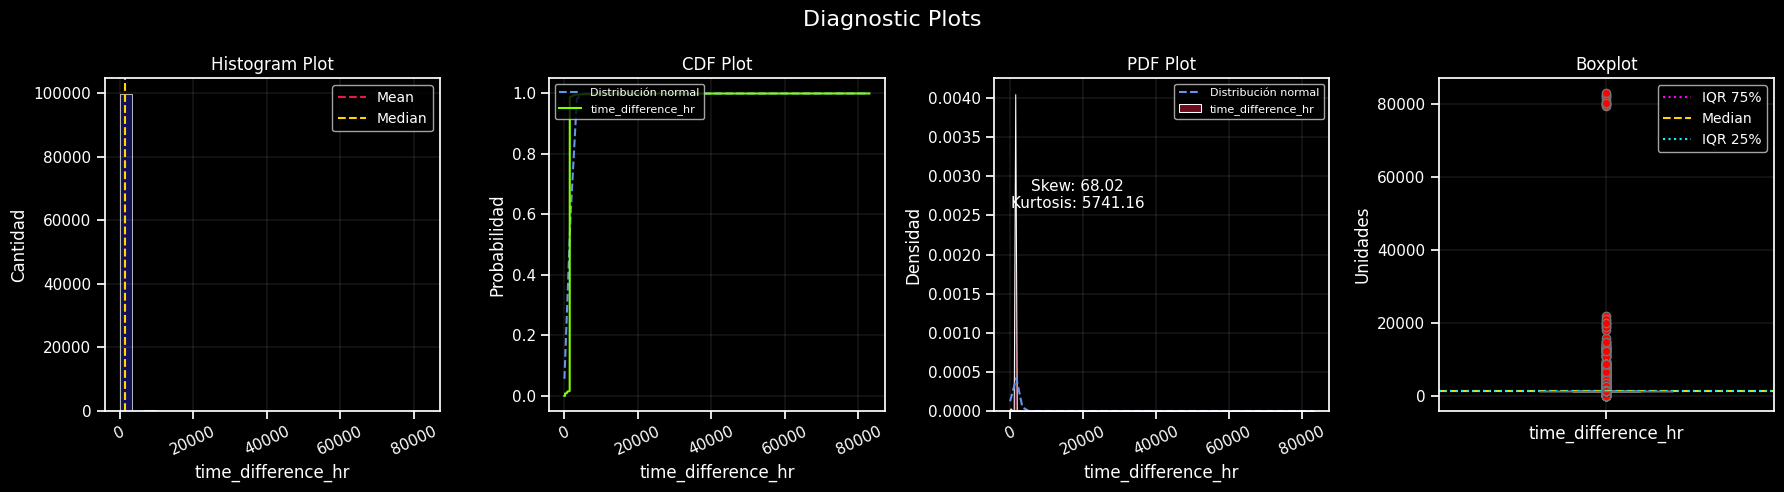

In [14]:
# Función para observar el comportamiento de variables continuas
diagnostic_plots(
    data=data.loc[:, data.columns != 'condition'], 
    variables=continuous
)

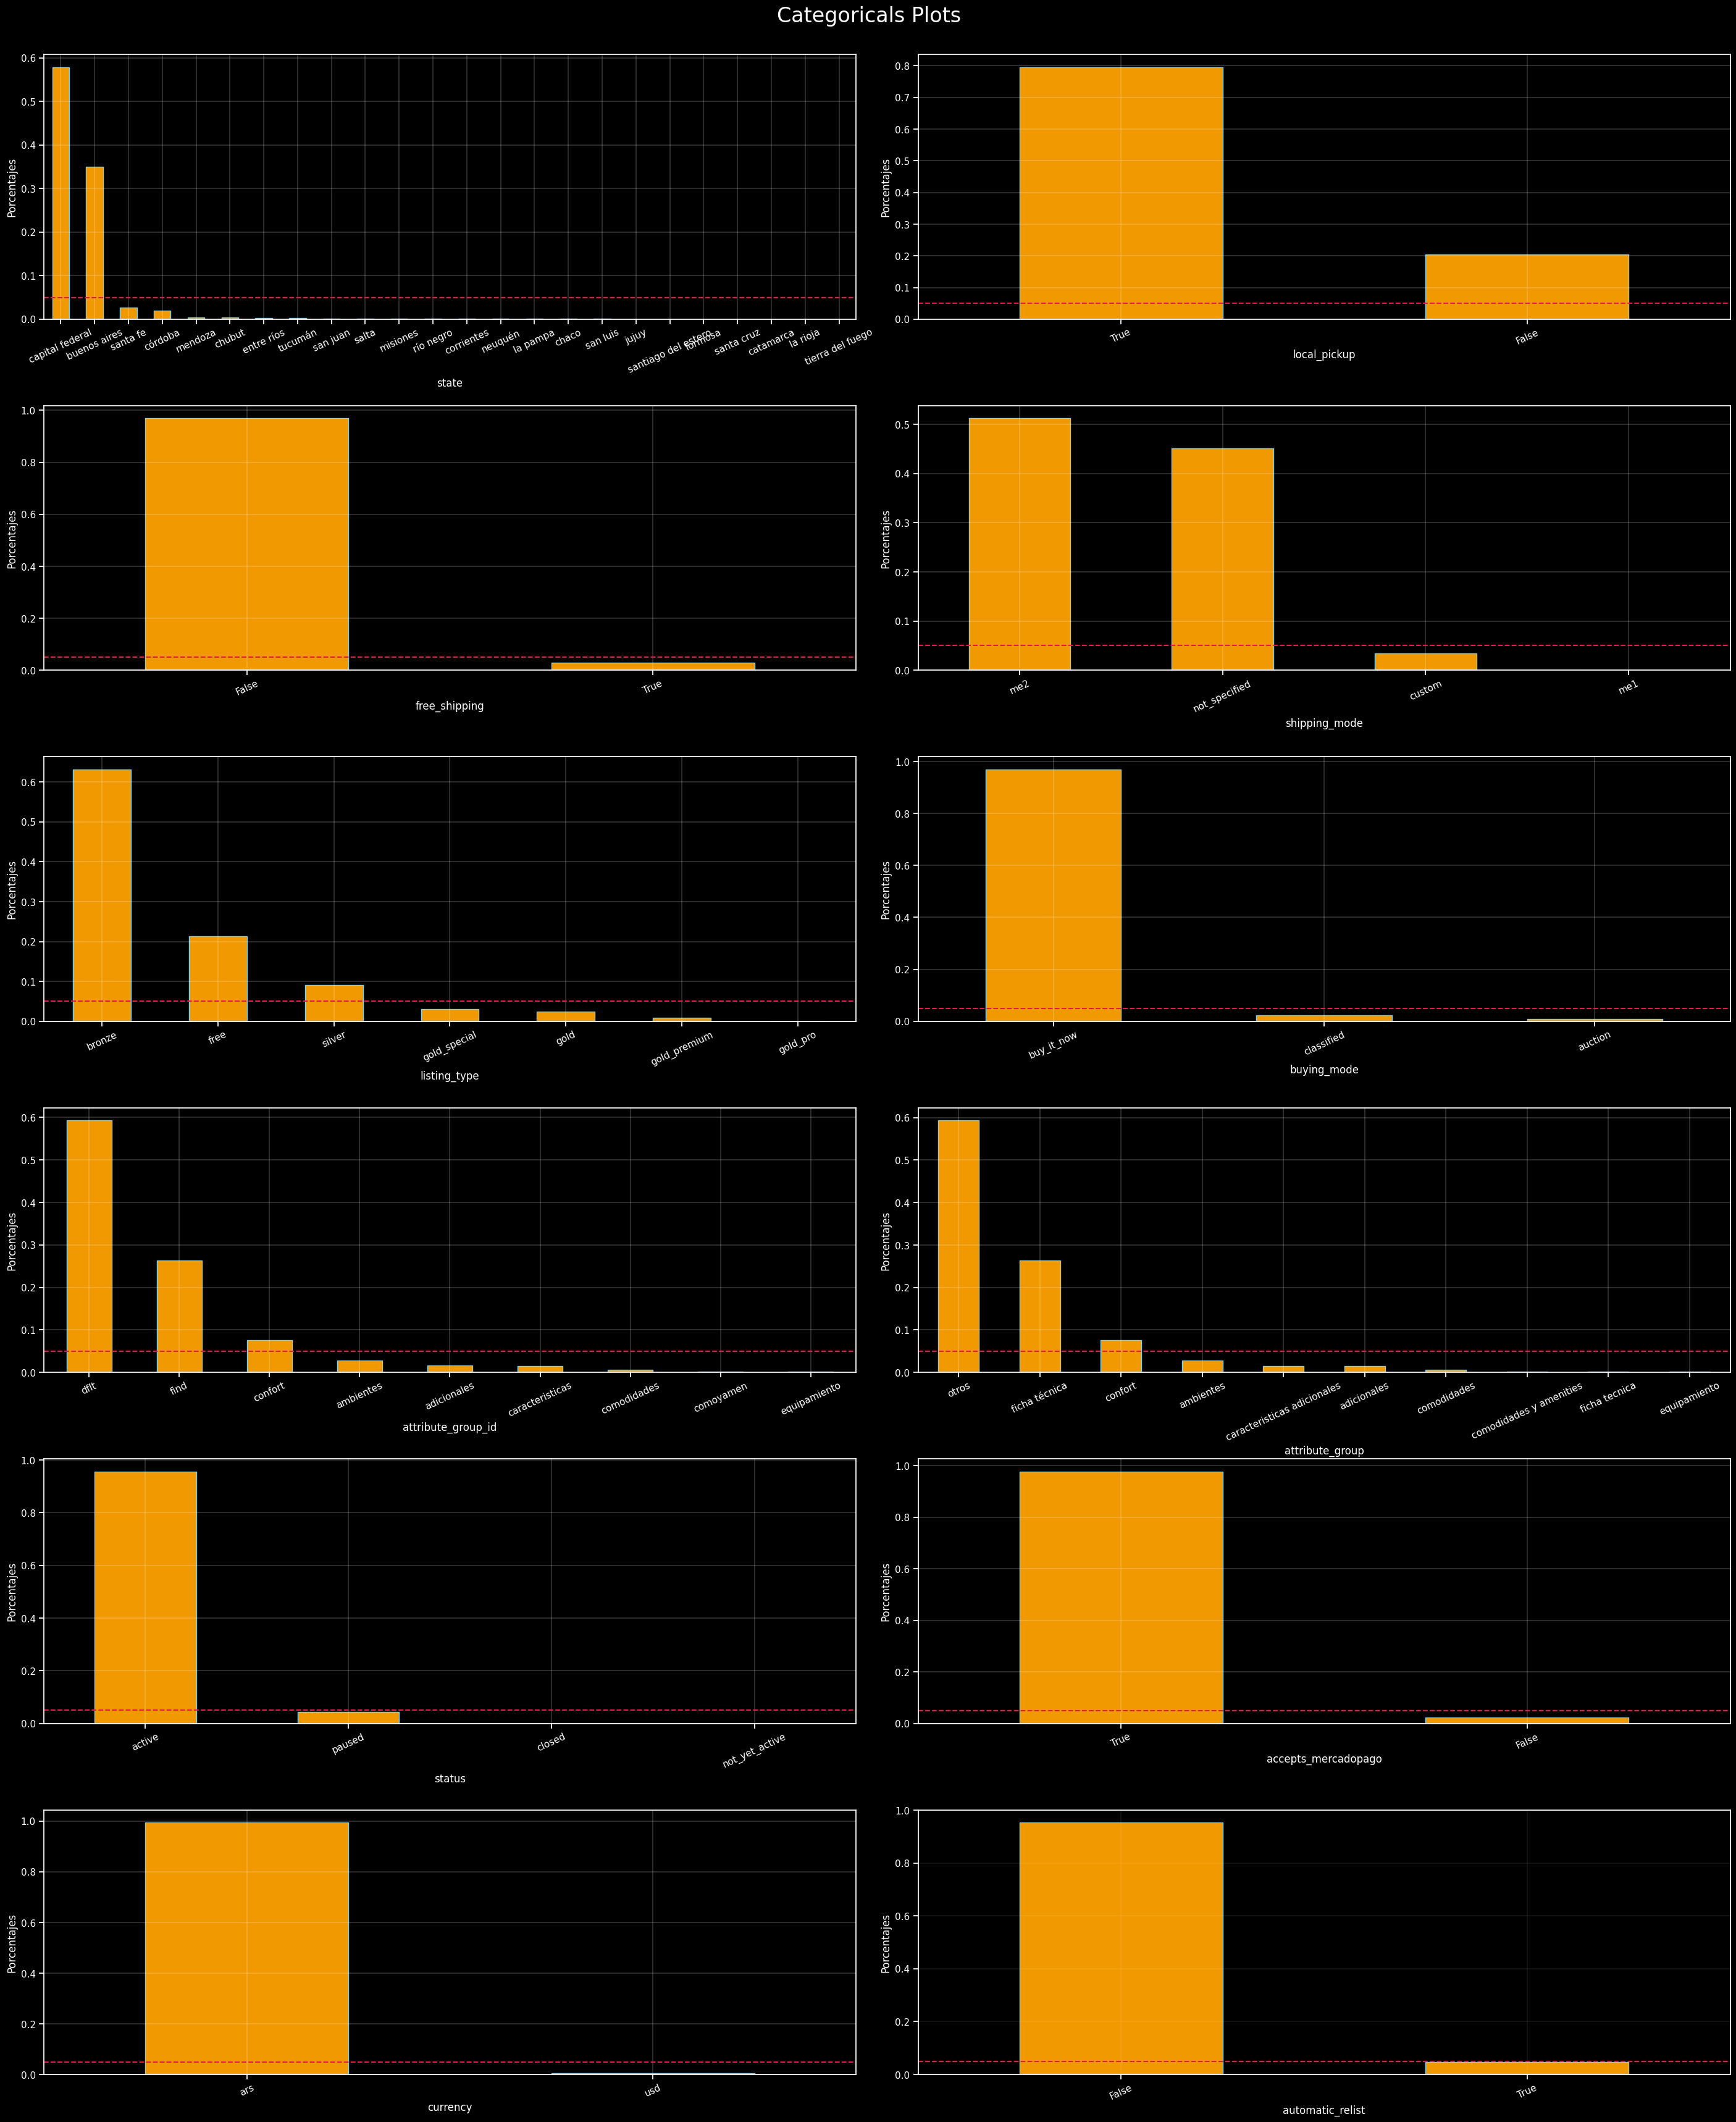

In [15]:
# Función para observar el comportamiento de variables categóricas
categoricals_plot(
    data=data.loc[:, data.columns != 'condition'], 
    variables=[var for var in categoricals if var not in ['attribute_id', 'city']]
)

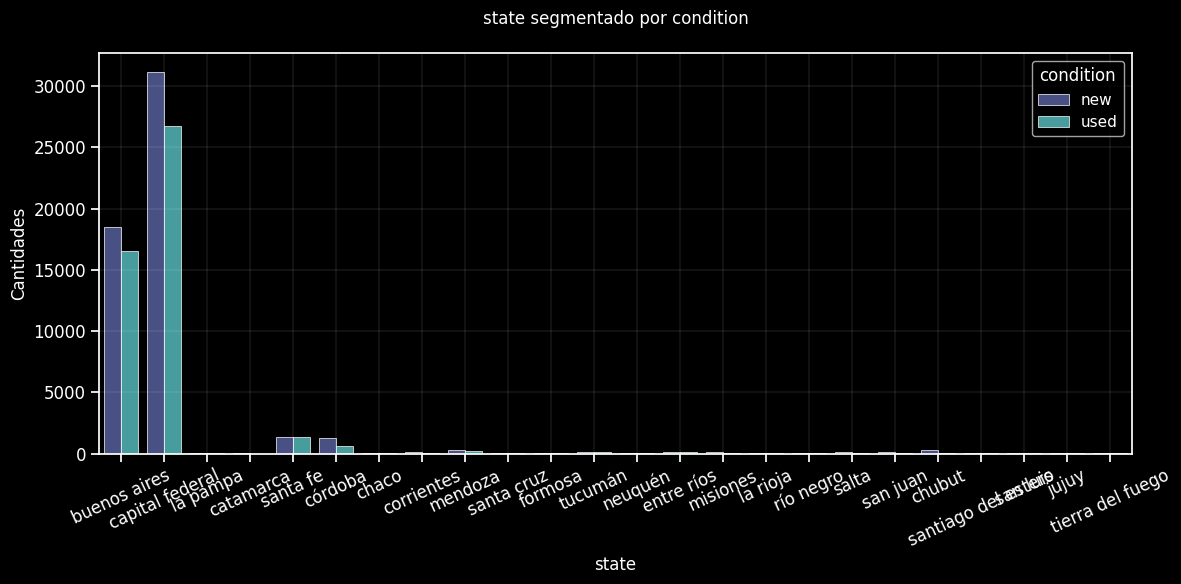

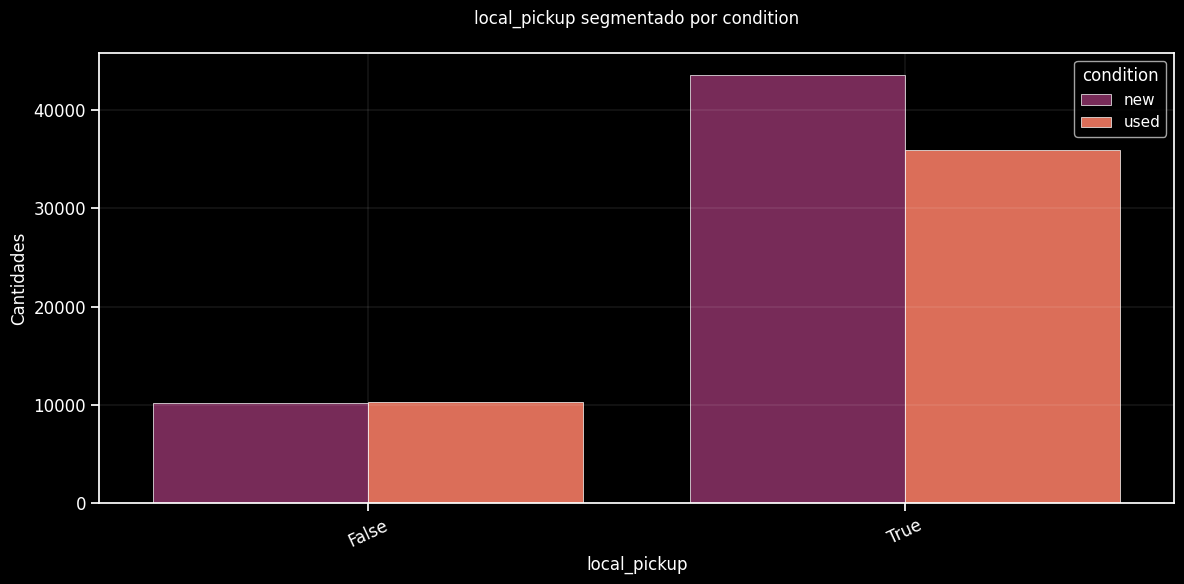

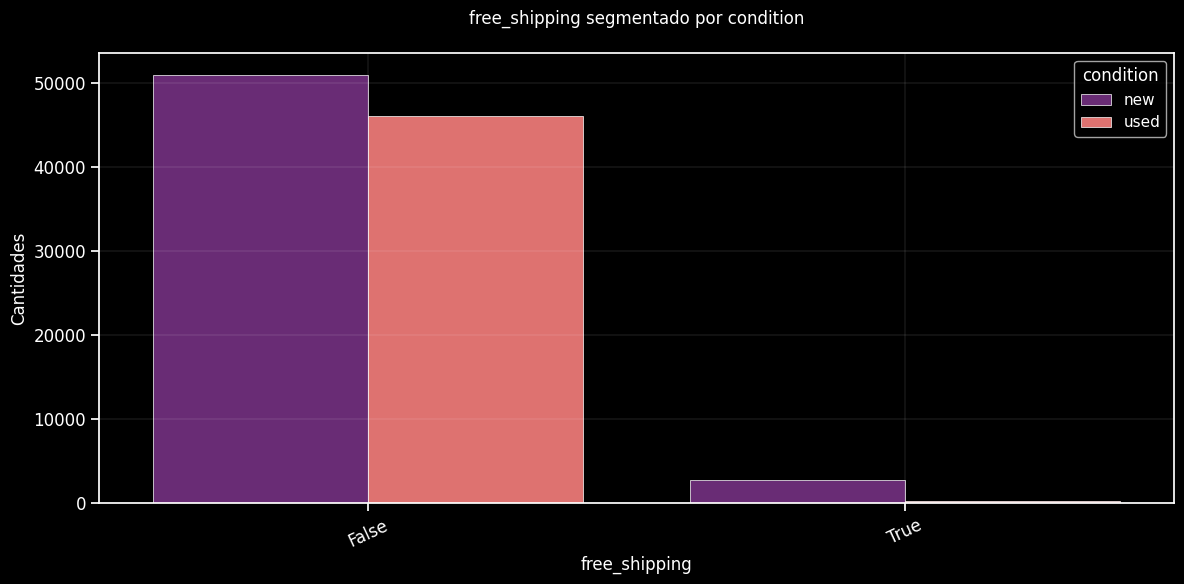

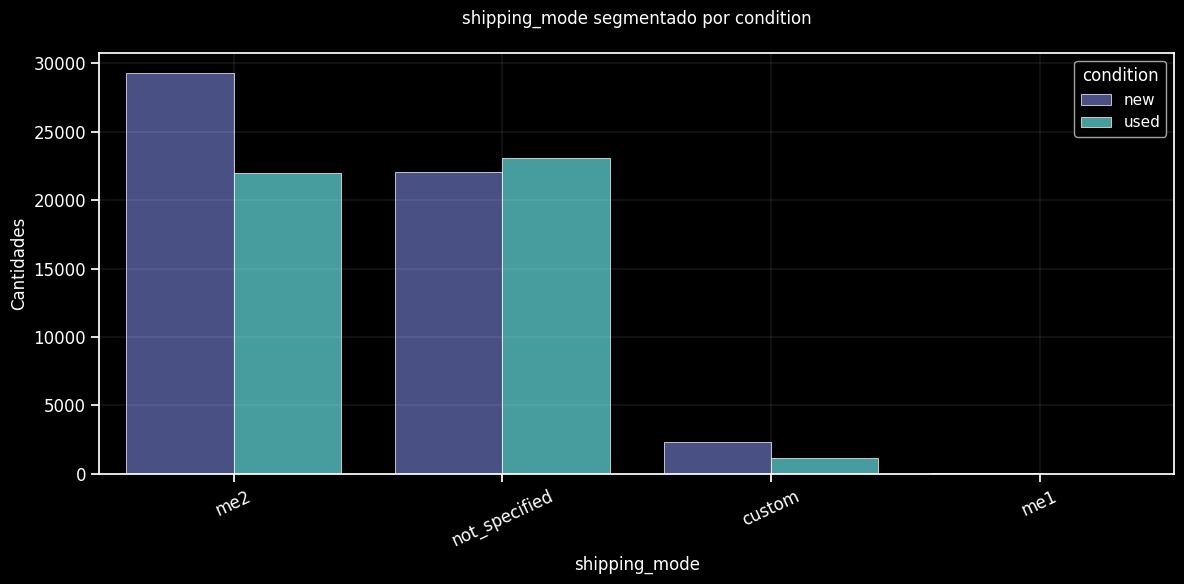

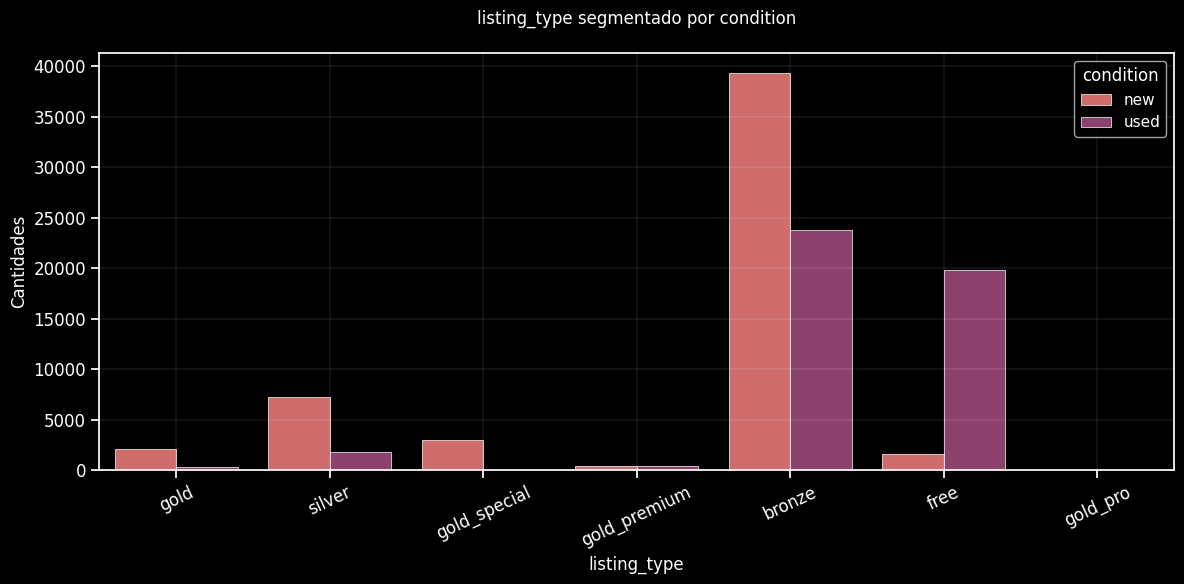

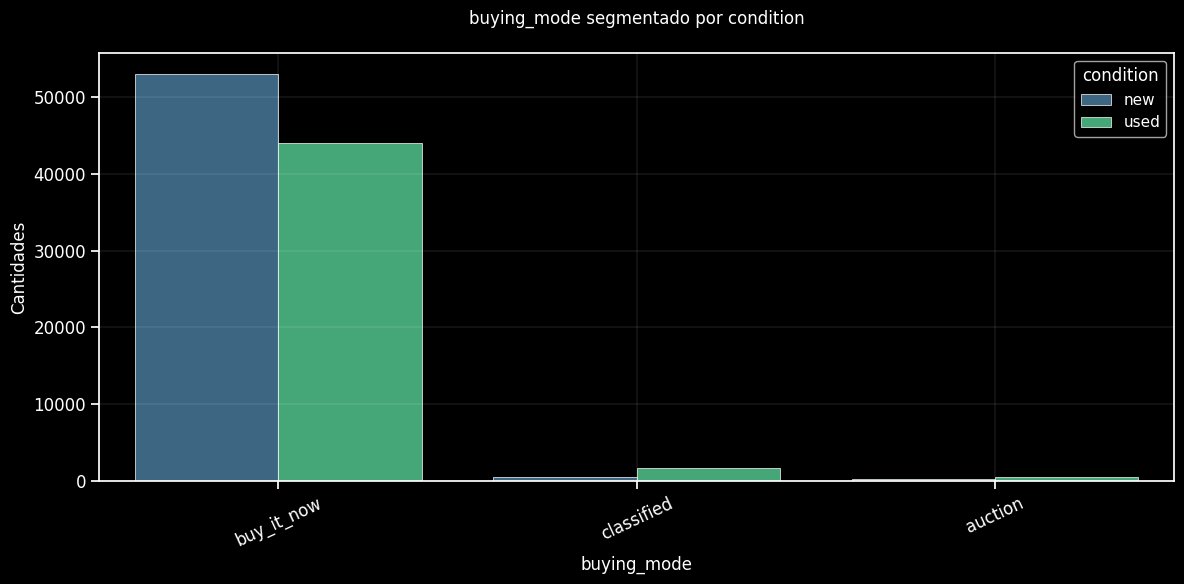

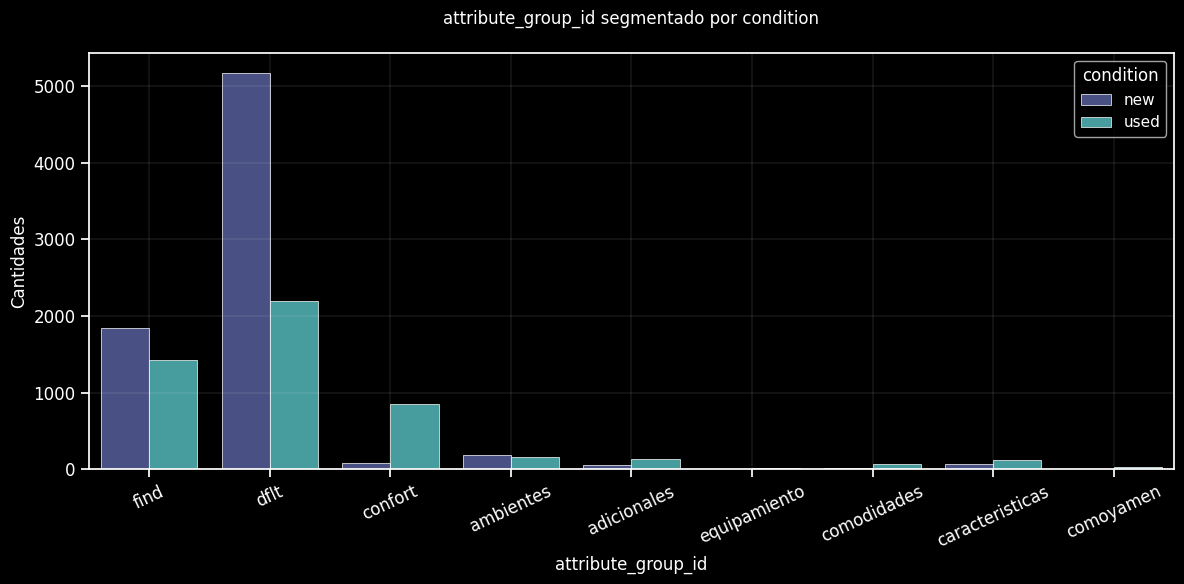

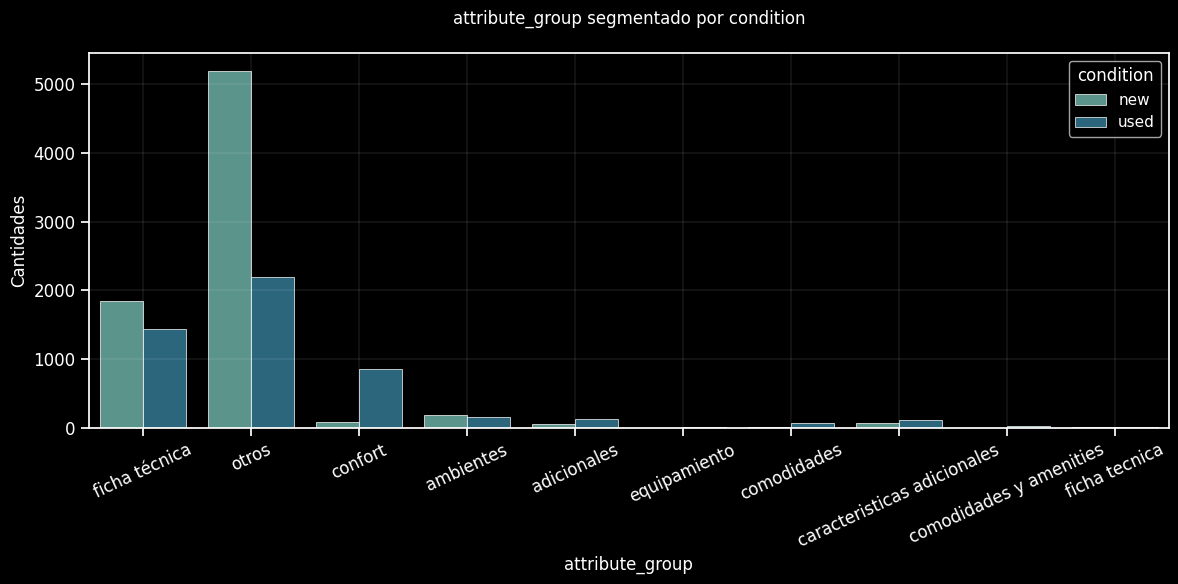

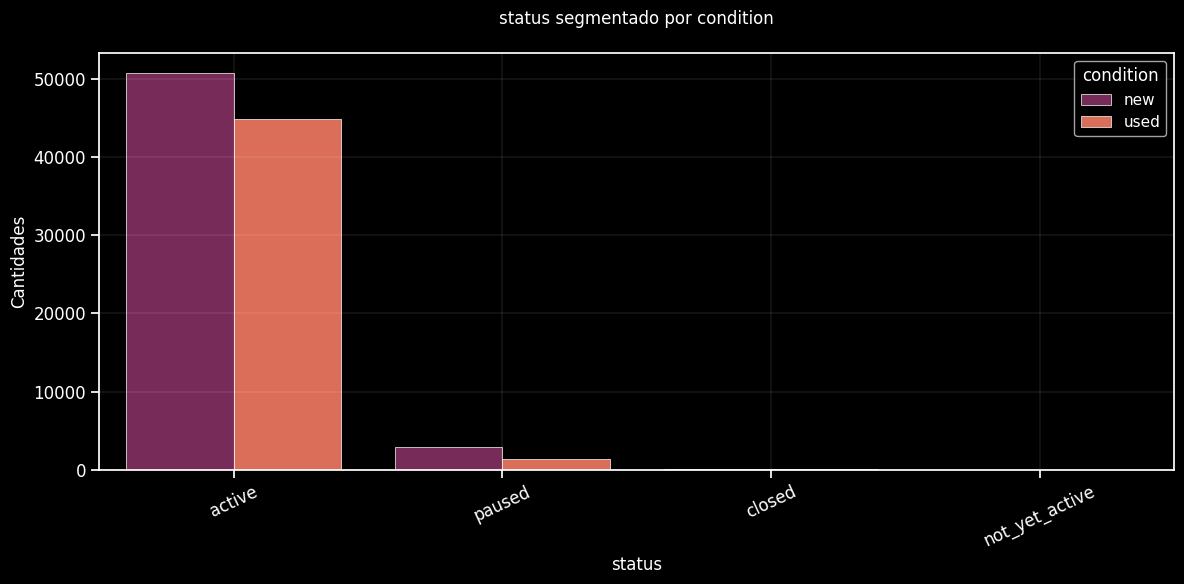

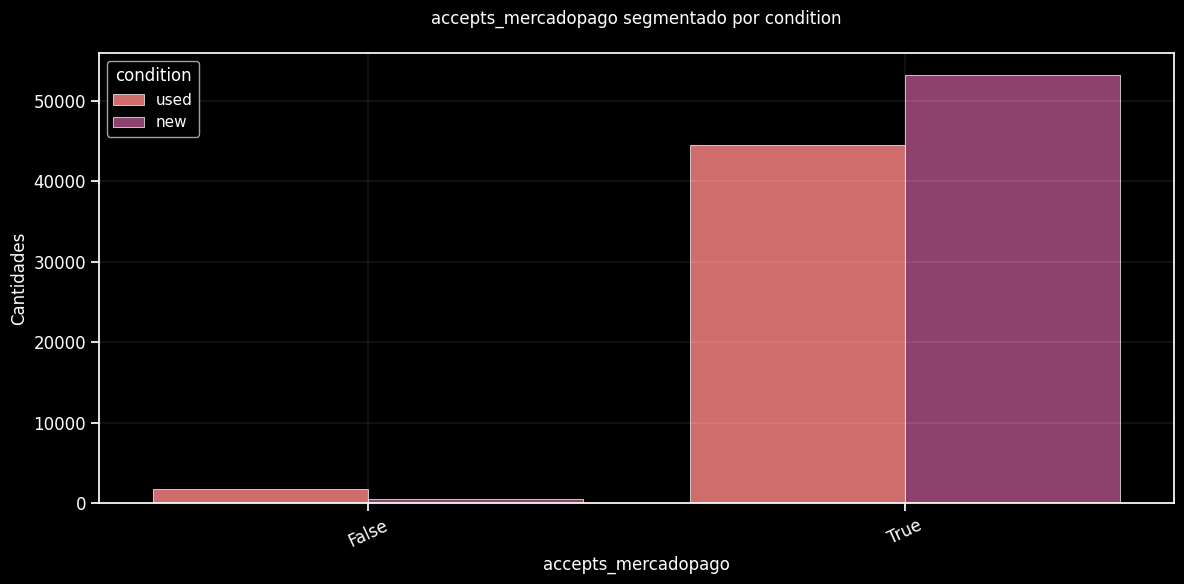

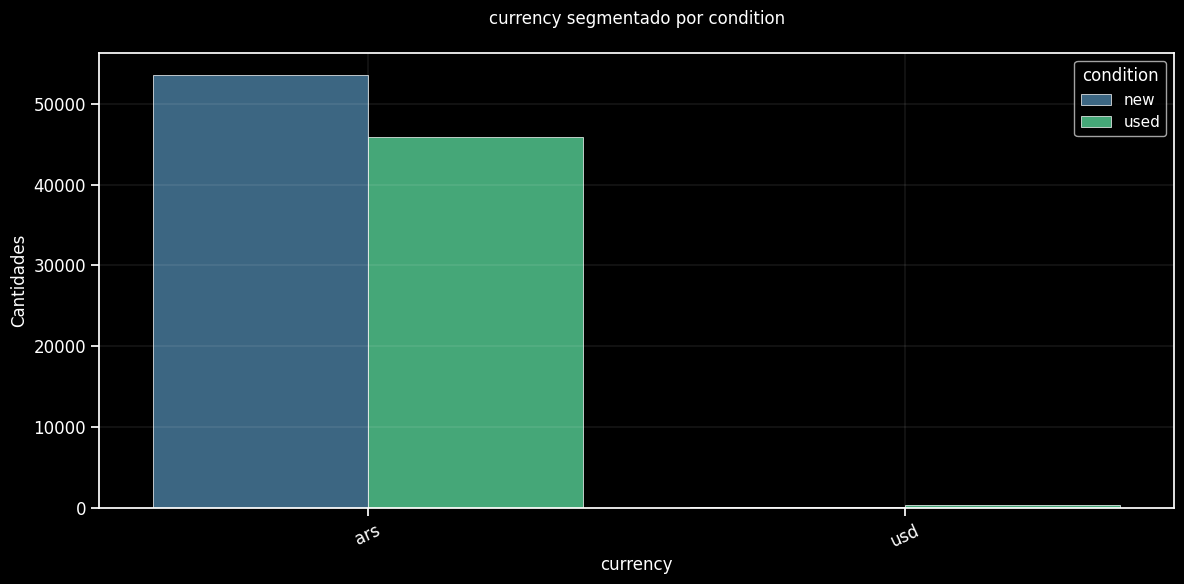

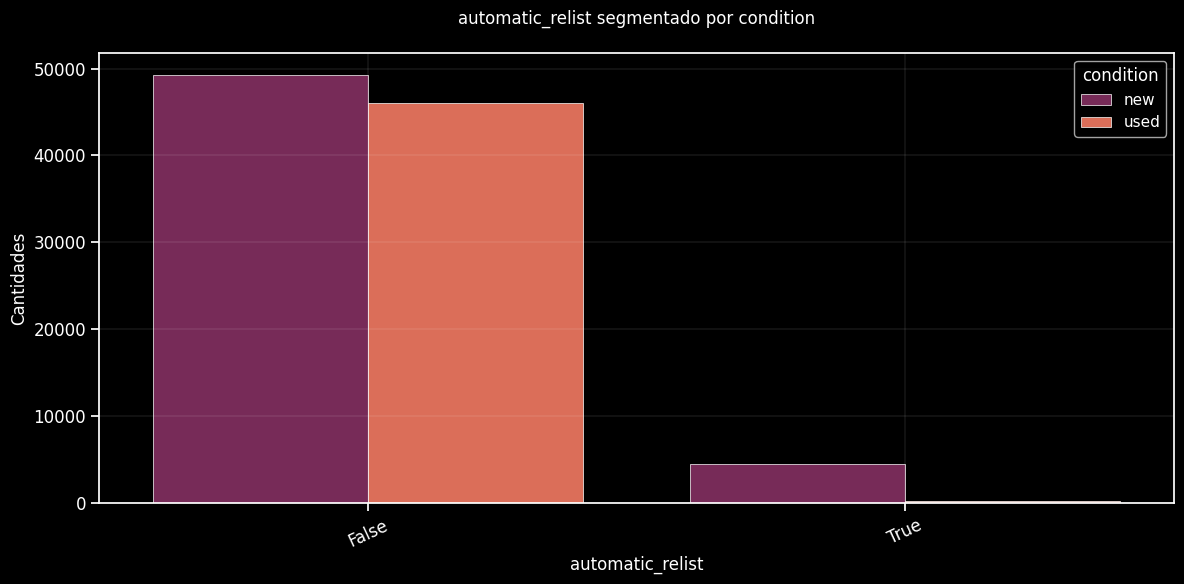

In [16]:
# Función para graficar las categóricas segmentadas por el target
categoricals_hue_target(
    data=data,
    variables=[var for var in categoricals if var not in ['attribute_id', 'city']],
    target='condition'
)